# scVelo-RNA velocity analysis of keratinocytes

# Part. Computing RNA velocity using CellRank

## RNA velocity per condition

In [11]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import os
import pandas as pd
import anndata as ad
from scipy import io
import loompy
from scipy.sparse import coo_matrix, csr_matrix
import sys

scv.logging.print_version()
sc.logging.print_header()

Running scvelo 0.2.4 (python 3.8.12) on 2022-03-09 20:25.


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.1 python-igraph==0.9.9 louvain==0.7.1 pynndescent==0.5.6


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI's XMLRPC API is currently disabled due to unmanageable load and will be deprecated in the near future. See https://status.python.org/ for more information.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
cr.settings.presenter_view = True
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=300, frameon=False) # for beautified visualization
cr.settings.verbosity = 2

import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

... storing 'orig.ident' as categorical
... storing 'Patient' as categorical
... storing 'Gender' as categorical
... storing 'Condition' as categorical
... storing 'Doublet' as categorical
... storing 'Phase' as categorical
... storing 'MainCellTypes' as categorical
... storing 'SubCellTypes' as categorical
... storing 'CellTypes' as categorical
... storing 'KRT6A_class' as categorical
... storing 'KRT6B_class' as categorical
... storing 'KRT6C_class' as categorical
... storing 'KRT16_class' as categorical
... storing 'KRT17_class' as categorical


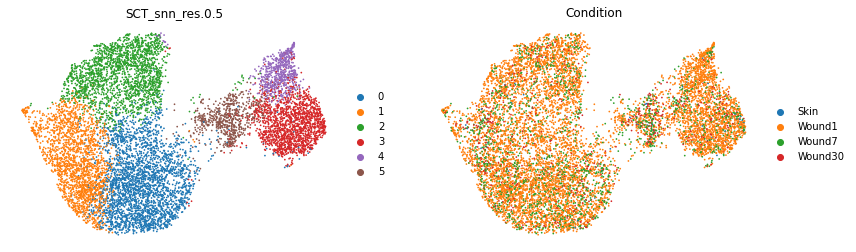

In [2]:
# load sparse matrix:
X = io.mmread('./p_try_KRT6A_wound_cells_scVelo/counts_w.mtx')

# create anndata object
adata = ad.AnnData(
    X=X.transpose().tocsr()
)

# load cell metadata:
cell_meta = pd.read_csv("./p_try_KRT6A_wound_cells_scVelo/metadata_w.csv")
# convert just columns "Age" and "SCT_snn_res.0.5".... to category
cell_meta[["Age"]] = cell_meta[["Age"]].astype('category')
cell_meta[["SCT_snn_res.1"]] = cell_meta[["SCT_snn_res.1"]].astype('category')
cell_meta[["seurat_clusters"]] = cell_meta[["seurat_clusters"]].astype('category')
cell_meta[["SCT_snn_res.0.8"]] = cell_meta[["SCT_snn_res.0.8"]].astype('category')
cell_meta[["SCT_snn_res.0.5"]] = cell_meta[["SCT_snn_res.0.5"]].astype('category')

# load gene names:
with open("./p_try_KRT6A_wound_cells_scVelo/gene_names_w.csv", 'r') as f:
    gene_names = f.read().splitlines()
    
# set anndata observations and index obs by barcodes, var by gene names
adata.obs = cell_meta
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

# load dimensional reduction:
pca = pd.read_csv("./p_try_KRT6A_wound_cells_scVelo/pca_w.csv")
pca.index = adata.obs.index

harmony = pd.read_csv("./p_try_KRT6A_wound_cells_scVelo/harmony_w.csv")
harmony.index = adata.obs.index

# set pca, harmony and umap
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_harmony'] = harmony.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(), adata.obs['UMAP_2'].to_numpy())).T

# remember to delete unneeded columns
adata.obs = adata.obs.drop(columns=['barcode'])

# plot a UMAP colored by clusters to test:
sc.pl.umap(adata, color=['SCT_snn_res.0.5', 'Condition'], frameon=False, save=None) # legend_loc='on data',  

In [5]:
# save dataset as anndata format
#adata.write('./pySCENIC/allNew_scanpy_subkeratins.h5ad', compression='gzip')

In [3]:
adata

AnnData object with n_obs × n_vars = 10064 × 25778
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Patient', 'Gender', 'Age', 'Condition', 'Doublet', 'percent.mt', 'percent.ribo', 'percent.hb', 'percent.malat1', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'MainCellTypes', 'SubCellTypes', 'CellTypes', 'mig_score1', 'KRT6A_class', 'KRT6B_class', 'KRT6C_class', 'KRT16_class', 'KRT17_class', 'SCT_snn_res.0.8', 'seurat_clusters', 'SCT_snn_res.0.5', 'SCT_snn_res.1', 'UMAP_1', 'UMAP_2'
    uns: 'SCT_snn_res.0.5_colors', 'Condition_colors'
    obsm: 'X_pca', 'X_harmony', 'X_umap'

In [16]:
ldata = loompy.connect('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/allwounds_pyVelocyto_w.loom',
                      mode='r+')

In [23]:
genes=pd.read_csv('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/myfile_wound_final_clean.csv')

In [27]:
keep=genes['genes'].values

In [35]:
ldata[ldata.ra["Gene"] == keep,:]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
adata_sub = adata[:, adata.var.index.isin(genes[['genes']].values.ravel())]

In [39]:
ldata.ra["Gene"].isin(genes[['genes']].values)

AttributeError: 'numpy.ndarray' object has no attribute 'isin'

In [40]:
ldata.ra["Gene"]

array(['ENSG00000278704', 'ENSG00000277400', 'MAFIP', ..., 'DAZ4', 'CDY1',
       'TTTY3'], dtype=object)

In [29]:
ldata
#adata.var.index.isin(genes[['genes']].values.ravel())

,,,,,,CellID,PWH26D0_AAAGTCCTCATGGTAC-1,PWH26D0_AAAGTGAAGAGCGACT-1,PWH26D0_AACAAGAAGGCAGGTT-1,PWH26D0_AACAAGACATTGACAC-1,PWH26D0_AAAGAACAGTGCTAGG-1,PWH26D0_AAAGGGCCATACTGAC-1,PWH26D0_AAAGGTAAGCCAGTAG-1,PWH26D0_AAAGTGATCTTAATCC-1,PWH26D0_AACCAACTCAACGTGT-1,PWH26D0_AACACACCACAGCCAC-1,...
,,,,,,Clusters,0,0,0,0,5,6,4,0,5,4,...
,,,,,,_X,36.976967,24.57494,19.308289,28.357069,4.290935,-48.228653,-25.804213,27.374283,-9.408419,-18.479511,...
,,,,,,_Y,-6.6888046,-12.704603,1.5517758,-12.274246,27.560024,-3.0285294,-18.545553,-3.3347528,-18.246346,-9.711372,...
Accession,Chromosome,End,Gene,Start,Strand,,,,,,,,,,,,...
ENSG00000278704,GL000009.2,58376,ENSG00000278704,56140,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSG00000277400,GL000194.1,115018,ENSG00000277400,53590,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSG00000274847,GL000194.1,115055,MAFIP,53594,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSG00000276256,GL000195.1,49164,ENSG00000276256,42939,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSG00000278198,GL000195.1,179372,ENSG00000278198,173872,+,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
ENSG00000273496,GL000205.2,104855,ENSG00000273496,99351,-,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...


In [9]:
ldata=sc.read_hdf('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/velocyto_analysis_woundcells.hdf5')

TypeError: read_hdf() missing 1 required positional argument: 'key'

In [20]:
# load loom files for spliced/unspliced matrices for each sample:
ldata1 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH26D0.loom', cache=True)
ldata2 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH26D1.loom', cache=True)
ldata3 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH26D30.loom', cache=True)
ldata4 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH26D7.loom', cache=True)
ldata5 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH27D0.loom', cache=True)
ldata6 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH27D1.loom', cache=True)
ldata7 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH27D30.loom', cache=True)
ldata8 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH27D7.loom', cache=True)
ldata9 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH28D0.loom', cache=True)
ldata10 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH28D1.loom', cache=True)
ldata11 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH28D30.loom', cache=True)
ldata12 = scv.read('/Users/zhuliu/Desktop/scRNA_STseq/proj_10X_woundhealing/03_results/00-Velocyto_loomFiles/PWH28D7.loom', cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [21]:
# rename barcodes in order to merge:
barcodes = [bc.replace(':', '_') for bc in ldata1.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata1.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata2.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata2.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata3.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata3.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata4.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata4.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata5.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata5.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata6.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata6.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata7.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata7.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata8.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata8.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata9.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata9.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata10.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata10.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata11.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata11.obs.index = barcodes

barcodes = [bc.replace(':', '_') for bc in ldata12.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '-1' for bc in barcodes]
ldata12.obs.index = barcodes

In [22]:
# make variable names unique
ldata1.var_names_make_unique()
ldata2.var_names_make_unique()
ldata3.var_names_make_unique()
ldata4.var_names_make_unique()
ldata5.var_names_make_unique()
ldata6.var_names_make_unique()
ldata7.var_names_make_unique()
ldata8.var_names_make_unique()
ldata9.var_names_make_unique()
ldata10.var_names_make_unique()
ldata11.var_names_make_unique()
ldata12.var_names_make_unique()

In [23]:
# concatenate the three loom
ldata = ldata1.concatenate([ldata2, ldata3, ldata4, ldata5, ldata6, ldata7, ldata8, ldata9, ldata10, ldata11, ldata12])

In [24]:
# Check the overlapped gene number
len(pd.unique(adata.var_names.intersection(ldata.var_names)))

25755

In [25]:
# check and rename the index of merged loom file
barcodes =  ldata1.obs.index.tolist() + ldata2.obs.index.tolist() + ldata3.obs.index.tolist() + ldata4.obs.index.tolist() + ldata5.obs.index.tolist() + ldata6.obs.index.tolist() + ldata7.obs.index.tolist() + ldata8.obs.index.tolist() + ldata9.obs.index.tolist() + ldata10.obs.index.tolist() + ldata11.obs.index.tolist() + ldata12.obs.index.tolist() 
ldata.obs.index = barcodes

In [26]:
# Check the overlapped cell number
len(pd.unique(adata.obs_names.intersection(ldata.obs_names)))

10064

In [27]:
# merge ldata matrices (to be merged) into the original adata (reference data set) object
adata = scv.utils.merge(adata, ldata)

In [65]:
adata.layers['spliced']

<27105x25755 sparse matrix of type '<class 'numpy.uint16'>'
	with 95892355 stored elements in Compressed Sparse Row format>

In [28]:
# save dataset as anndata format
adata.write('p_try_KRT6A_wound_cells.h5ad', compression='gzip')